In [1]:
# some variables/calculations apply to all the subsets of data (all figures).
# to apply these, run '%run All_notebooks.ipynb' in the first cell of a notebook.
# Note that several variable names will be pre-defined, including:
# lcl(), data, tthr, sthr, sample_dictionary, transfected, a, bins

In [2]:
# import packages
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import FixedLocator
import seaborn as sns
import xarray as xr
import flowkit as fk
import bioviper as bv
import glob
import os
from scipy.stats import linregress, ttest_ind, f_oneway, pearsonr

In [3]:
# configure interactive plots
%matplotlib ipympl

In [4]:
# set parameters for plots/visualization
SMALL_SIZE = 7
MEDIUM_SIZE = 7
BIGGER_SIZE = 7

plt.rcParams['svg.fonttype'] = 'none'    # makes text editable in exported .svg files
plt.rcParams['font.sans-serif'] = 'Arial'# set font for all plots to Arial

plt.rc('font', family='Arial')
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [5]:
# set up logicle transform for visualizing distributions
xform = fk.transforms.LogicleTransform('lcl_231014', param_t=40000, param_w=0.5, param_m=4.5, param_a=0) # for un-normalized data
# xform = fk.transforms.LogicleTransform('lcl_norm', param_t=3500, param_w=0.5, param_m = 4.5, param_a = 0)

def lcl(data):
    
    xform = fk.transforms.LogicleTransform('lcl_231014', param_t=40000, param_w=0.5, param_m=4.5, param_a=0) # for un-normalized data
    # xform = fk.transforms.LogicleTransform('lcl_norm', param_t=3500, param_w=0.5, param_m = 4.5, param_a = 0)
    
    if isinstance(data, pd.DataFrame):
        smpl = fk.Sample(data, sample_id='data')
        smpl.apply_transform(xform)
        out = pd.DataFrame(data = smpl.get_events(source = 'xform'), index = data.index, columns = data.columns)
    elif isinstance(data, pd.Series):
        d = data.to_numpy()
        out = pd.Series(data = xform.apply(d), index = data.index, name = data.name)
    elif isinstance(data, np.ndarray):
        out = xform.apply(data)
    elif isinstance(data, list):
        out = xform.apply(np.array(data))
    else:
        out = xform.apply(np.array([data]))[0]
    
    return out

In [6]:
# load in data
data = pd.concat([pd.read_csv(f) for f in glob.glob('./out/*.csv')])
data = data.set_index(list('ESR')+['CellID'])

In [7]:
data

area      mCherry       FITC
E      S           R CellID                              
231117 10x+gA11dC- 0 0        865    77.568786  26.947821
                     1        342     3.108187  15.021243
                     2        321     7.772586  27.462040
                     3       1371  1515.328957  47.239030
                     4       1052     3.891635  18.085561
...                           ...          ...        ...
240131 mock        2 510     1073     1.939422   7.008262
                     511      688     2.953488   9.175814
                     512     1242     2.968599   8.809295
                     513      460     3.656522  11.239109
                     514      410     1.643902   6.947634

[835767 rows x 3 columns]

In [8]:
# thresholding (note that threshold values are calcuated from the entire data set)
tthr = data['mCherry'].xs('mock', level = 'S').quantile(0.995) # transfection threshold
sthr = data['FITC'].loc[pd.IndexSlice[:,['gC3FL-','gA11dC-']]].quantile(0.995) # surface stain threshold

In [9]:
# printing sample names as they were recorded with the data
data.index.unique('S')

Index(['10x+gA11dC-', '10xdC+', '12x+gA11dC-', '12xdC+', '5x+gA11dC-', '5xdC+',
       'a4+10x', 'a4+12x', 'a4+5x', 'a4+gA11dC-', 'a4+gC3FL-', 'a4dCmCh+',
       'gA11dC+', 'gA11dC-', 'gC3FL+', 'mock', '14xdC+', 'b17FL+', 'b17ec56',
       'gA11ec56', 'gB6dC+', 'gB6dsdC', 'gB6ec56', 'gC3FL-', 'gC3FL-unstained',
       'gC3ec56*', '22xdC+', 'b17dsdC', 'gA11dsdC', 'gC3dsdC', 'gC3ec56',
       'gA1dsdC', 'gA3dC+', 'gA3dsdC', 'gB2dC+', 'gB2dsdC', 'gB6FL+',
       'gC3dsFL', 'a4-gC3rdsFL', 'a4-gC3rdsdC', 'a4dCdEC6', 'aC2FL+', 'aC2dC+',
       'gC3dC+', '14x+gA11dC-', '22x+gA11dC-', 'a4+14x', 'a4+22x', 'aC2dsdC',
       'gC3FL+unstained'],
      dtype='object', name='S')

In [10]:
# matching sample names recorded with the data to sample names for the plots
samples = ['10x+gA11dC-', '10xdC+', '12x+gA11dC-', '12xdC+', '5x+gA11dC-', '5xdC+',
       'a4+10x', 'a4+12x', 'a4+5x', 'a4+gA11dC-', 'a4+gC3FL-', 'a4dCmCh+',
       'gA11dC+', 'gA11dC-', 'gC3FL+', 'mock', '14xdC+', 'b17FL+', 'b17ec56',
       'gA11ec56', 'gB6dC+', 'gB6dsdC', 'gB6ec56', 'gC3FL-', 'gC3FL-unstained',
       'gC3ec56*', '22xdC+', 'b17dsdC', 'gA11dsdC', 'gC3dsdC', 'gC3ec56',
       'gA1dsdC', 'gA3dC+', 'gA3dsdC', 'gB2dC+', 'gB2dsdC', 'gB6FL+',
       'gC3dsFL', 'a4-gC3rdsFL', 'a4-gC3rdsdC', 'a4dCdEC6', 'aC2FL+', 'aC2dC+',
       'gC3dC+', '14x+gA11dC-', '22x+gA11dC-', 'a4+14x', 'a4+22x', 'aC2dsdC',
       'gC3FL+unstained']
names = ['10x+γA11', r'α4-10x$_{γB6}$', '12x+γA11', r'α4-12x$_{γB6}$', '5x+γA11', r'α4-5x$_{γB6}$',
         'α4+10x', 'α4+12x', 'α4+5x', 'α4+γA11', 'α4+γC3', 'α4',
         'γA11', 'untagged γA11', 'γC3', 'mock', r'α4-14x$_{γB6}$', 'β17', r'α4-β17$_{EC5-6}$',
         r'α4-γA11$_{EC5-6}$', 'γB6', r'α4-γB6$_{EC6}$', r'α4-γB6$_{EC5-6}$', 'untagged γC3', 'unstained γC3-',
         r'α4-γC3$_{EC5-6}$*', r'α4-22x$_{γB6}$', r'α4-β17$_{EC6}$', r'α4-γA11$_{EC6}$', r'α4-γC3$_{EC6}$', r'α4-γC3$_{EC5-6}$',
         r'α4-γA1$_{EC6}$', 'γΑ3', r'α4-γA3$_{EC6}$', 'γB2', r'α4-γB2$_{EC6}$', 'γB6FL',
         r'α4FL-γC3$_{EC6}$', r'γC3FL-α4$_{EC6}$', r'γC3Δcyto-α4$_{EC6}$', 'α4ΔEC6', 'αC2', 'αC2Δcyto',
         'γC3Δcyto', '14x+γA11', '22x+γA11', 'α4+14x', 'α4+22x', r'α4-αC2$_{EC6}$',
         'unstained γC3+']
sample_dictionary = {s : n for s, n in zip(samples, names)}

In [11]:
# quantile binning based on all transfected cells in the dataset
transfected = data[data['mCherry'] > tthr].drop('mock', level = 'S') # dataframe of transfected cells
transfected['bin'], bins = pd.qcut(transfected['mCherry'], 50, retbins = True)

In [12]:
# function for calculating the bin means (FP and Ab) and linear fit parameters for subsets of data
def binning(df, bins, gpby):
    """
    Parameters
    ----------
    
    df : pd.DataFrame
        Subset of the data to split among bins.
    bins : array
        Array of values that define the edges of the bins. Has length nbins + 1.
    gpby : index level name or list of names
        'group by'; specifies which index levels to use for combining data.
        e.g. use 'list("ES")' to perform calculations separately for each experiment and sample, or
        e.g. use 'S' to aggregate all experiments together by sample.
        
    Returns
    -------
    
    binned : pd.DataFrame
        Dataframe with the information as the input df but additionally
        specifying 'bin', 'FPbin', and 'Abbin' values for each cell.
    lr : pd.DataFrame
        Dataframe containing the linear regression fit parameters.
    """
    
    if 'mock' in df.index.unique('S'):
        df = df.drop('mock', level = 'S')

    binmeans = df.groupby(gpby).apply(lambda x: x.groupby(pd.cut(x['mCherry'], bins).rename('B')).mean()).rename(columns = {'mCherry' : 'FPbin', 'FITC' : 'Abbin'})

    lr = binmeans[binmeans['Abbin'] >= 0].groupby(gpby).apply(lambda x: linregress(np.log(x['FPbin']),np.log(x['Abbin'])))
    # Note that bins with mean Abbin values equal to or below zero are excluded from the linear fit.
    # Mean FPbin values will never be equal to or below zero because tthr is greater than zero.
    lines = pd.DataFrame(index = lr.index, columns = ['slope', 'intercept', 'r', 'p', 'stderr'])
    for k, col in enumerate(lines.columns):
        lines[col] = [lr[j][k] for j in lr.index]
        
    return binmeans, lines

In [13]:
def quickplot(subset, norm_sample = 'gC3FL+', reorder = False, limitx = True, height = 3):
    
    t = subset['mCherry'] > tthr
    s = subset['FITC'] > sthr
    
    transfected = subset[t]
    
    sde_es = (t&s)[t].groupby(list('ES')).mean()
    sde_es.name = 'FITC'
    sde_s = (t&s)[t].groupby('S').mean()
    sde_s.name = 'FITC'

    norm = transfected['FITC'].xs(norm_sample, level = 'S').mean()
    ab_es = transfected['FITC'].groupby(list('ES')).mean()/norm
    ab_s = transfected['FITC'].groupby('S').mean()/norm

    bn_es, E_es = binning(transfected, bins, list('ES'))
    bn_s, E_s = binning(transfected, bins, 'S')
    
    if reorder:
        order = subset.index.unique('S')[reorder]
    else:
        order = subset.index.unique('S')
    
    fig, axs = plt.subplots(1,3,layout = 'constrained', figsize = (6.5, height), sharey = True)

    for ax, each, name, plot, top in zip(
        axs,
        [(sde_es, sde_s), (ab_es, ab_s), (E_es['slope'], E_s['slope'])],
        ['FITC', 'FITC','slope'],
        [r'$f^+$', r'$\overline{Ab}$', r'$E_{surface}$'],
        ['Stained cell fraction', r'Mean Ab$_{cell}$ signal', 'Slope of dose-response'], ):

        sns.barplot(
            data = each[1].loc[order].reset_index(),
            y = 'S',
            x = name,
            ax = ax,
            color = '0.5',
            # hue = 'S', palette = [clrd[j] for j in each[1].reset_index()['S']],
        )
        sns.swarmplot(
            data = each[0].loc[pd.IndexSlice[:,order]].reset_index(),
            y = 'S',
            x = name,
            ax = ax,
            s = 3,
            color = 'k',
        )
        ax.set_ylabel(None)
        ax.set_yticks(ax.get_yticks(), [sample_dictionary[o] for o in each[1].loc[order].reset_index()['S']])
        ax.spines[['top','right']].set_visible(False)
        ax.set_xlabel(plot)
        ax.set_title(top)
    
    if limitx:
        axs[0].set_xlim(0,1)

    plt.show()
    
    return [sde_es, sde_s, ab_es, ab_s, E_es, E_s, bn_es, bn_s, transfected, t, s]

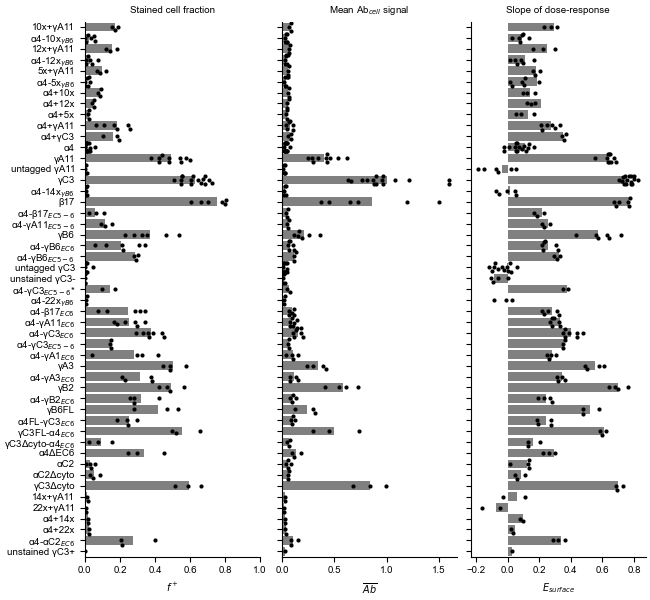

In [14]:
show = quickplot(data.drop('mock', level = 'S'), height = 6)

In [15]:
def logticks(ax, xaxis = True, yaxis = True):
    
    tickrange = np.array([-100, -10, 1, 10, 100, 1000, 10000, 100000])
    minorticks = np.array([np.arange(0,n,n/10)[1:] for n in tickrange[tickrange > 0]]).ravel()
    
    if xaxis: 
        minx, maxx = [np.e**j for j in ax.get_xlim()]
        xticks = np.array([x for x in tickrange if x > minx and x < maxx])
        ax.set_xticks(np.log(xticks), xticks)
        
        minorxticks = np.array([x for x in minorticks if x > minx and x < maxx])
        ax.xaxis.set_minor_locator(FixedLocator(np.log(minorxticks)))
        
    if yaxis:
        miny, maxy = [np.e**j for j in ax.get_ylim()]
        yticks = np.array([y for y in tickrange if y > miny and y < maxy])
        ax.set_yticks(np.log(yticks), yticks)
        
        minoryticks = np.array([y for y in minorticks if y > miny and y < maxy])
        ax.yaxis.set_minor_locator(FixedLocator(np.log(minoryticks)))

In [16]:
def rearrange(series, ssel, isoforms):
    # ssel = ['mock','gC3FL-','a4dCmCh+','a4dCdEC6','aC2dsdC','aC2FL+','aC2dC+','gA3dsdC','gA3dC+','gA11dsdC','gA11ec56','gA11dC+','gB2dsdC','gB2dC+','gB6dsdC','gB6ec56','gB6dC+','b17dsdC','b17ec56','b17FL+','gC3dsdC','gC3ec56','gC3FL+','gC3dC+']
    # isoforms = ['aC2', 'gA3', 'gA11', 'gB2', 'gB6', 'gC3', 'b17']
    ec6swaps = []
    wildtype = []
    for iso in isoforms:
        a = [each for each in ssel if iso in each and 'dsdC' in each]
        b = [each for each in ssel if iso in each and '+' in each]

        if a:
            a = a[0]
        if len(b) > 1:
            if iso == 'gB6':
                b = [each for each in b if 'dC+' in each]
                b = b[0]
            else:
                b = [each for each in b if 'FL' in each]
                b = b[0]
        else:
            b = b[0]

        ec6swaps.append(a)
        wildtype.append(b)

    wtd = {j : i for j, i in zip(wildtype,isoforms)}
    swd = {j : i for j, i in zip(ec6swaps,isoforms)}
    
    if series.name:
        col = series.name
    else:
        col = 0

    wt_frame = series.loc[pd.IndexSlice[:,wildtype]].reset_index()
    wt_frame['I'] = [wtd[j] for j in wt_frame['S']]
    wt_frame = wt_frame.set_index(list('EI'))[col]

    sw_frame = series.loc[pd.IndexSlice[:,ec6swaps]].reset_index()
    sw_frame['I'] = [swd[j] for j in sw_frame['S']]
    sw_frame = sw_frame.set_index(list('EI'))[col]
    
    return pd.concat([wt_frame, sw_frame], axis = 1, keys = ['wildtype','EC6-swaps']).dropna(how = 'any')

In [17]:
def correlate(a):
    return pearsonr(a['wildtype'],a['EC6-swaps'])

In [18]:
hist_kws = {
    # 'legend' : True,
    'common_bins' : True,
    'element' : 'step',
    'common_norm' : False,
    'stat' : 'density',
    'kde' : False,
    'fill' : False,
    'common_norm' : False,
    # 'hue_order' : smpl,
    # 'palette' : pal,
    'kde' : False
}

In [19]:
sde_es, sde_s, ab_es, ab_s, E_es, E_s, bn_es, bn_s, transfected, t, s = show

In [20]:
# f+ (surface delivery efficiency) divided by experiment and sample
sde_es
# sde_es.to_csv('./calc_metrics/f+_es.csv')

E       S              
230916  10xdC+             0.008903
        12xdC+             0.006382
        5xdC+              0.002824
        a4+gC3FL-          0.195459
        a4dCmCh+           0.006350
                             ...   
240201  gC3FL+             0.547236
        gC3FL-             0.005130
        gC3FL-unstained    0.000000
        gC3dsdC            0.334473
        gC3ec56            0.147968
Name: FITC, Length: 223, dtype: float64

In [21]:
# f+ (surface delivery efficiency) divided by sample
sde_s
# sde_s.to_csv('./calc_metrics/f+_s.csv')

S
10x+gA11dC-        0.173906
10xdC+             0.024144
12x+gA11dC-        0.152951
12xdC+             0.029015
14x+gA11dC-        0.014559
14xdC+             0.008640
22x+gA11dC-        0.006881
22xdC+             0.008487
5x+gA11dC-         0.096502
5xdC+              0.013576
a4+10x             0.084936
a4+12x             0.045963
a4+14x             0.018262
a4+22x             0.023534
a4+5x              0.022323
a4+gA11dC-         0.181515
a4+gC3FL-          0.162068
a4-gC3rdsFL        0.556873
a4-gC3rdsdC        0.091171
a4dCdEC6           0.339362
a4dCmCh+           0.017440
aC2FL+             0.030534
aC2dC+             0.052712
aC2dsdC            0.272092
b17FL+             0.751398
b17dsdC            0.245678
b17ec56            0.056571
gA11dC+            0.490276
gA11dC-            0.004745
gA11dsdC           0.250300
gA11ec56           0.112309
gA1dsdC            0.281261
gA3dC+             0.500324
gA3dsdC            0.313716
gB2dC+             0.491945
gB2dsdC           

In [22]:
# Ab_bar (mean surface signal) dividied by experiment and sample
ab_es
# ab_es.to_csv('./calc_metrics/ab-bar_es.csv')

E       S              
230916  10xdC+             0.029551
        12xdC+             0.024269
        5xdC+              0.020034
        a4+gC3FL-          0.081917
        a4dCmCh+           0.031306
                             ...   
240201  gC3FL+             0.873301
        gC3FL-             0.014884
        gC3FL-unstained    0.012400
        gC3dsdC            0.119076
        gC3ec56            0.067238
Name: FITC, Length: 223, dtype: float64

In [23]:
# Ab_bar (mean surface signal) divided by sample
ab_s
# ab_s.to_csv('./calc_metrics/ab-bar_s.csv')

S
10x+gA11dC-        0.080496
10xdC+             0.037413
12x+gA11dC-        0.072131
12xdC+             0.040934
14x+gA11dC-        0.029376
14xdC+             0.025949
22x+gA11dC-        0.021023
22xdC+             0.022900
5x+gA11dC-         0.057309
5xdC+              0.036497
a4+10x             0.060289
a4+12x             0.055271
a4+14x             0.032766
a4+22x             0.033703
a4+5x              0.045506
a4+gA11dC-         0.077203
a4+gC3FL-          0.074092
a4-gC3rdsFL        0.494035
a4-gC3rdsdC        0.065400
a4dCdEC6           0.130858
a4dCmCh+           0.036676
aC2FL+             0.060152
aC2dC+             0.061655
aC2dsdC            0.105344
b17FL+             0.857621
b17dsdC            0.093839
b17ec56            0.045715
gA11dC+            0.401568
gA11dC-            0.021504
gA11dsdC           0.100414
gA11ec56           0.054145
gA1dsdC            0.104511
gA3dC+             0.343208
gA3dsdC            0.114274
gB2dC+             0.585587
gB2dsdC           

In [24]:
# E_surface (surface delivery efficiency) dividied by experiment and sample
E_es
# E_es.to_csv('./calc_metrics/E-surface_es.csv')

slope  intercept         r             p    stderr
E      S                                                                     
230916 10xdC+           0.134062   2.318982  0.825115  1.720304e-13  0.013249
       12xdC+           0.043797   2.676217  0.415445  2.697786e-03  0.013841
       5xdC+            0.108948   2.121043  0.657638  2.838272e-07  0.018204
       a4+gC3FL-        0.346204   1.951099  0.918250  6.079545e-21  0.021550
       a4dCmCh+         0.106064   2.525457  0.617173  1.810140e-06  0.019517
...                          ...        ...       ...           ...       ...
240201 gC3FL+           0.788228   1.178627  0.991974  8.970923e-45  0.014502
       gC3FL-          -0.101474   3.017001 -0.666717  1.694424e-07  0.016546
       gC3FL-unstained -0.089486   2.839445 -0.643941  5.985140e-07  0.015508
       gC3dsdC          0.439757   1.777700  0.927826  3.411605e-22  0.025518
       gC3ec56          0.351093   1.856595  0.890499  4.909573e-18  0.025892

[223 rows x 5 columns]

In [25]:
# E_surface (surface delivery efficiency) divided by sample
E_s
# E_s.to_csv('./calc_metrics/E-surface_s.csv')

,slope,intercept,r,p,stderr
S,,,,,
10x+gA11dC-,0.294022,2.416593,0.943725,1.042342e-24,0.014873
10xdC+,0.093082,2.814859,0.791627,7.685019e-12,0.010370
12x+gA11dC-,0.251492,2.575663,0.874109,1.152974e-16,0.020171
12xdC+,0.111186,2.844639,0.689130,3.143574e-08,0.016875
14x+gA11dC-,0.062010,2.662782,0.327620,2.020420e-02,0.025812
14xdC+,0.015966,2.832201,0.082386,5.694979e-01,0.027878
22x+gA11dC-,-0.073666,3.104351,-0.409338,3.159551e-03,0.023700
22xdC+,0.005367,2.745965,0.028003,8.469264e-01,0.027653
5x+gA11dC-,0.182234,2.733785,0.876544,7.423345e-17,0.014443
